#### A quick demonstration of patchy tau (amplitude modulation) reconstruction in fullsky
#### - this code shows how to compute the estiamtors, and output their power spectra

In [1]:
import numpy as np, basic, curvedsky, plottools as pl
from matplotlib.pyplot import *

In [18]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 50.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)

#### load unlensed and lensed Cls

In [19]:
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,lmax,4,bb=True)/Tcmb**2
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

In [20]:
l, ntt = np.loadtxt('../data/Al_TT_dr2_smica_Lmask_a0.0deg_cinv_l100-2048.dat',unpack=True,usecols=(0,1))

#### calculate normalizations

In [21]:
Al = {}
Al['tTT'] = curvedsky.norm_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
Al['tEB'] = curvedsky.norm_tau.qeb(lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])

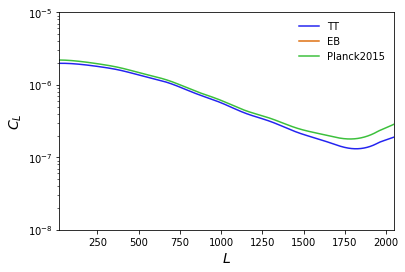

In [22]:
pl.plot_1dstyle(ylog=True,ymin=1e-8,ymax=1e-5)
plot(L,Al['tTT'],label='TT')
plot(L,Al['tEB'],label='EB')
plot(l,ntt,label='Planck2015')
legend()

In [23]:
Al['lTT'], __ = curvedsky.norm_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
#Al['lEB'], c = curvedsky.norm_lens.qeb(lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])
Al['xTT'] = curvedsky.norm_lens.ttt(lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
Il = 1./(1.-Al['tTT']*Al['lTT']*Al['xTT']**2)
Al['qTT'] = Al['tTT']*Il
#Il = 1./(1.-Al['lEB']*Al['tEB']*Al['xEB']**2)
#Al['lEB'] = Al['lEB']*Il

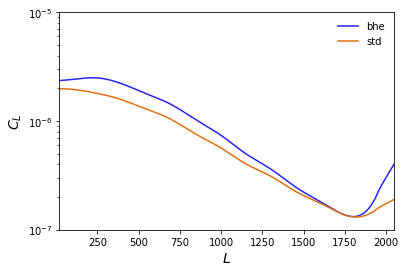

In [26]:
pl.plot_1dstyle(ylog=True,ymin=1e-7,ymax=1e-5)
plot(L,Al['qTT'],label='bhe')
plot(L,Al['tTT'],label='std')
legend()

In [8]:
# simple diagonal c-inverse
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [9]:
# generate CMB alms 
# - gaussian alms are generated, and the reconstructed cls are equal to the normalization
Talm, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
tlm = curvedsky.utils.gauss1alm(lmax,1e-5*np.exp(-(L/500.)**2))

In [10]:
# modulate amplitude in map space
nside = 2048
npix  = 12*nside**2
tau  = curvedsky.utils.hp_alm2map(nside,lmax,lmax,tlm)
Tmap = curvedsky.utils.hp_alm2map(nside,lmax,lmax,Talm)
Talm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,Tmap*(1.+tau))
Qmap, Umap = curvedsky.utils.hp_alm2map_spin(nside,lmax,lmax,2,Ealm,Balm)
Ealm, Balm = curvedsky.utils.hp_map2alm_spin(nside,lmax,lmax,2,Qmap*(1.+tau),Umap*(1.+tau))

In [11]:
# add noise
Talm += curvedsky.utils.gauss1alm(lmax,nl[0,:])
Ealm += curvedsky.utils.gauss1alm(lmax,nl[1,:])
Balm += curvedsky.utils.gauss1alm(lmax,nl[2,:])

In [12]:
# diagonal filtering
Talm *= Fl[0,:,:]
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

In [13]:
# compute unnormalized estiamtors
alm = {}
alm['tTT'] = curvedsky.rec_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,nside=1024)
#alm['qEB'] = curvedsky.rec_tau.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)
alm['lTT'], __ = curvedsky.rec_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,nside=1024)

In [14]:
# normalized estimators
for qest in ['lTT','tTT']:
    alm[qest] *= Al[qest][:,None]

In [15]:
# bhe
alm['qTT'] = alm['tTT'] - Al['tTT'][:,None]*Al['xTT'][:,None]*alm['lTT']
alm['qTT'] *= Il[:,None]

In [16]:
# compute cross spectra
xl = {}
for qest in ['qTT','tTT']:
    xl[qest] = curvedsky.utils.alm2cl(lmax,alm[qest],tlm)
tl = curvedsky.utils.alm2cl(lmax,tlm)

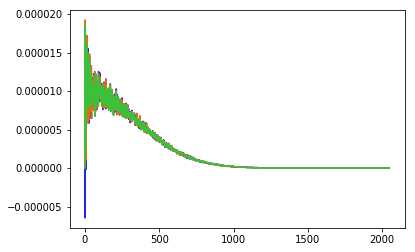

In [17]:
plot(xl['qTT'])
plot(xl['tTT'])
plot(tl)